# Исследовательский анализ данных и проверка гипотез для сервиса Яндекс Афиша

Автор: Фалеторов Кирилл   
Дата: 09.11.2025

**Цель:**  
Провести комплексный анализ данных о продажах билетов для выявления сезонных закономерностей, ключевых сегментов и драйверов выручки, а также проверить гипотезы об активности пользователей разных устройств.

**Задачи:**  
1. Загрузить данных и познакомииться с ними.
2. Предобработать данные и подготовить их к исследованию.
3. Провести исследовательский анализ данных.  
     3.1 Провести анализ распределения заказов по сегментам и их сезонные изменения.   
     3.2 Изучить активность пользователей осенью 2024 года.  
     3.3 Изучить события распределены по регионам и партнёрам.  
4. Провести статистический анализ данных.
5. Написать общий вывод и рекомендации — на что обратить внимание.
     

Данные для исследование сервиса Яндекс Афиша состоят из трех датасетов:

Первый датасет **final_tickets_orders_df.csv** включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных.     
order_id — уникальный идентификатор заказа.  
user_id — уникальный идентификатор пользователя.  
created_dt_msk — дата создания заказа (московское время).  
created_ts_msk — дата и время создания заказа (московское время).  
event_id — идентификатор мероприятия из таблицы events.  
cinema_circuit — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.  
age_limit — возрастное ограничение мероприятия.  
currency_code — валюта оплаты, например rub для российских рублей.  
device_type_canonical — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.  
revenue — выручка от заказа.  
service_name — название билетного оператора.  
tickets_count — количество купленных билетов.  
total — общая сумма заказа.  

Второй датасет **final_tickets_events_df** содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия.    
event_id — уникальный идентификатор мероприятия.  
event_name — название мероприятия. Аналог поля event_name_code из исходной базы данных.  
event_type_description — описание типа мероприятия.  
event_type_main — основной тип мероприятия: театральная постановка, концерт и так далее.  
organizers — организаторы мероприятия.  
region_name — название региона.  
city_name — название города.  
venue_id — уникальный идентификатор площадки.  
venue_name — название площадки.  
venue_address — адрес площадки.  

Третий датасет **final_tickets_tenge_df.csv** служит для удобства перевода данных к одной валюте, например к российским рублям.  
nominal — номинал (100 тенге).  
data — дата.  
curs — курс тенге к рублю.  
cdx — обозначение валюты (kzt).  

### Шаг 1. Знакомство с данными: загрузка и первичная предобработка
- Загрузите все данные по проекту.
- Проверьте названия столбцов.
- Выведите информацию, которая необходима вам для принятия решений о предобработке, для каждого из датасетов.

In [1]:
# Импортируем библиотеки
import pandas as pd
!pip install phik
import numpy as np
# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# Импортируем необходимую функцию
from scipy.stats import mannwhitneyu

In [2]:
# Загрузим данные и создадим датафреймы с заказами, событиями и курсами валют
orders_df= pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv')
events_df= pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_events_df.csv')
tenge_df= pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

Познакомимся с данными датасетов — выведем первые строки методом head(), а информацию о датафрейме методом info():

In [3]:
orders_df.head()


,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


In [4]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

In [5]:
orders_df.isna().sum()


order_id                     0
user_id                      0
created_dt_msk               0
created_ts_msk               0
event_id                     0
cinema_circuit               0
age_limit                    0
currency_code                0
device_type_canonical        0
revenue                      0
service_name                 0
tickets_count                0
total                        0
days_since_prev          21940
dtype: int64

In [6]:
orders_df.duplicated().sum()

0

Датасет orders_df содержит 14 столбцов и 290849 строк.  

После первичного анализа данных можно сделать следующие выводы:
- Названия столбцов в норме.
- Даты (created_dt_msk, created_ts_msk) хранятся как object (строки), а не как datetime.
- Пропуски содержатся в days_since_prev.
- Дубликатов нет.

In [7]:
orders_df['created_dt_msk'] = pd.to_datetime(orders_df['created_dt_msk'])
orders_df['created_ts_msk'] = pd.to_datetime(orders_df['created_ts_msk'])

orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   order_id               290849 non-null  int64         
 1   user_id                290849 non-null  object        
 2   created_dt_msk         290849 non-null  datetime64[ns]
 3   created_ts_msk         290849 non-null  datetime64[ns]
 4   event_id               290849 non-null  int64         
 5   cinema_circuit         290849 non-null  object        
 6   age_limit              290849 non-null  int64         
 7   currency_code          290849 non-null  object        
 8   device_type_canonical  290849 non-null  object        
 9   revenue                290849 non-null  float64       
 10  service_name           290849 non-null  object        
 11  tickets_count          290849 non-null  int64         
 12  total                  290849 non-null  floa

In [8]:
events_df.head()

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


In [9]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


In [10]:
events_df.isna().sum()


event_id                  0
event_name                0
event_type_description    0
event_type_main           0
organizers                0
region_name               0
city_name                 0
city_id                   0
venue_id                  0
venue_name                0
venue_address             0
dtype: int64

In [11]:
events_df.duplicated().sum()

0

Датасет events_df содержит 11 столбцов и 22427 строк.

После первичного анализа данных можно сделать следующие выводы:   
- Названия столбцов в норме.
- Типы данных в норме.
- Пропуски не содержатся.
- Дубликатов нет.

In [12]:
tenge_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [13]:
tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


In [14]:
tenge_df.isna().sum()

data       0
nominal    0
curs       0
cdx        0
dtype: int64

In [15]:
tenge_df.duplicated().sum()

0

Датасет events_df содержит 4 столбца и 357 строк.

После первичного анализа данных можно сделать следующие выводы:
- Названия столбцов в норме.
- Данные в data хранятся как object (строки), а не как datetime.
- Пропуски не содержатся.
- Дубликатов нет.

In [16]:
tenge_df['data'] = pd.to_datetime(tenge_df['data'])
tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     357 non-null    datetime64[ns]
 1   nominal  357 non-null    int64         
 2   curs     357 non-null    float64       
 3   cdx      357 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 11.3+ KB


In [17]:
#Объединение датафреймов
two_df=orders_df.merge(events_df, on='event_id', how='left') 
two_df.info()
two_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290849 entries, 0 to 290848
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290849 non-null  int64         
 1   user_id                 290849 non-null  object        
 2   created_dt_msk          290849 non-null  datetime64[ns]
 3   created_ts_msk          290849 non-null  datetime64[ns]
 4   event_id                290849 non-null  int64         
 5   cinema_circuit          290849 non-null  object        
 6   age_limit               290849 non-null  int64         
 7   currency_code           290849 non-null  object        
 8   device_type_canonical   290849 non-null  object        
 9   revenue                 290849 non-null  float64       
 10  service_name            290849 non-null  object        
 11  tickets_count           290849 non-null  int64         
 12  total                   290849

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4"
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6"
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,2f638715-8844-466c-b43f-378a627c419f,выставка,другое,№5049,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8"
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,10d805d3-9809-4d8a-834e-225b7d03f95d,шоу,стендап,№832,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8"


In [18]:
#Присоединим данные с курсами валют по дате
three_df= two_df.merge(tenge_df, how='left', left_on='created_dt_msk', right_on='data')
three_df.info()
three_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290849 entries, 0 to 290848
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290849 non-null  int64         
 1   user_id                 290849 non-null  object        
 2   created_dt_msk          290849 non-null  datetime64[ns]
 3   created_ts_msk          290849 non-null  datetime64[ns]
 4   event_id                290849 non-null  int64         
 5   cinema_circuit          290849 non-null  object        
 6   age_limit               290849 non-null  int64         
 7   currency_code           290849 non-null  object        
 8   device_type_canonical   290849 non-null  object        
 9   revenue                 290849 non-null  float64       
 10  service_name            290849 non-null  object        
 11  tickets_count           290849 non-null  int64         
 12  total                   290849

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,nominal,curs,cdx
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,100,18.6972,kzt
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-07-23,100,18.3419,kzt
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",2024-10-06,100,19.6475,kzt
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",2024-07-13,100,18.5010,kzt
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",2024-10-04,100,19.6648,kzt


Вывод: Знакомство с данными проведено, качество датасетов нормальное, необходимые строки привели в нужный тип.

### Шаг 2. Предобработка данных и подготовка их к исследованию


In [19]:
#Проверяем датафрейм на явные дубликаты
three_df.duplicated().sum()

0

Явных дубликатов не обнаружено.

In [20]:
three_df.duplicated(subset=['order_id']).sum()

0

Проверим датасет на неявные дубликаты по бронированию билета без учёта идентификаторов заказа.

In [21]:
# автоматически включаем все столбцы кроме order_id
columns_to_check = [col for col in three_df.columns if col != 'order_id']
duplicates = three_df.duplicated(subset=columns_to_check)

print('Количество неявных дубликатов:', duplicates.sum())
three_df[duplicates].head()
df_clean = three_df[~duplicates]

print(f"Размер DataFrame до удаления дубликатов: {len(three_df)}")
print(f"Размер DataFrame после удаления дубликатов: {len(df_clean)}")

Количество неявных дубликатов: 30
Размер DataFrame до удаления дубликатов: 290849
Размер DataFrame после удаления дубликатов: 290819


Причины неявных дубликатов:

- Многократные отправки форм пользователями  
- Технические сбои при обработке данных  
- Ошибки синхронизации между системами  
- Повторная обработка одних и тех же заказов

Из-за небольшого кол-во дубликатов, простым решением будет их удалить.

Анализ пропусков в данных событий после объединения

In [22]:

df_clean.isna().mean()

order_id                  0.000000
user_id                   0.000000
created_dt_msk            0.000000
created_ts_msk            0.000000
event_id                  0.000000
cinema_circuit            0.000000
age_limit                 0.000000
currency_code             0.000000
device_type_canonical     0.000000
revenue                   0.000000
service_name              0.000000
tickets_count             0.000000
total                     0.000000
days_since_prev           0.075442
event_name                0.000818
event_type_description    0.000818
event_type_main           0.000818
organizers                0.000818
region_name               0.000818
city_name                 0.000818
city_id                   0.000818
venue_id                  0.000818
venue_name                0.000818
venue_address             0.000818
data                      0.000000
nominal                   0.000000
curs                      0.000000
cdx                       0.000000
dtype: float64

In [23]:
df_clean.isna().sum()

order_id                      0
user_id                       0
created_dt_msk                0
created_ts_msk                0
event_id                      0
cinema_circuit                0
age_limit                     0
currency_code                 0
device_type_canonical         0
revenue                       0
service_name                  0
tickets_count                 0
total                         0
days_since_prev           21940
event_name                  238
event_type_description      238
event_type_main             238
organizers                  238
region_name                 238
city_name                   238
city_id                     238
venue_id                    238
venue_name                  238
venue_address               238
data                          0
nominal                       0
curs                          0
cdx                           0
dtype: int64

In [24]:
# Столбцы с информацией о событиях, содержащие пропуски
event_columns = [
    'event_name', 'event_type_description', 'event_type_main', 
    'organizers', 'region_name', 'city_name', 'city_id', 
    'venue_id', 'venue_name', 'venue_address'
]

# Поиск строк с пропусками в данных о событиях
mask = df_clean[event_columns].isna().any(axis=1)
rows_with_nan = df_clean[mask]

# Анализ отсутствующих событий
unique_event_ids = rows_with_nan['event_id'].unique()
print(f"Количество событий с отсутствующей информацией: {len(unique_event_ids)}")
print(f"ID событий с пропусками: {unique_event_ids}")

# Просмотр примеров записей с неполными данными
rows_with_nan.head()

Количество событий с отсутствующей информацией: 19
ID событий с пропусками: [533222 530296 532300 477731 536716 246804 536731 555671 548224 538260
 534151 536715 539336 553041 553435 548062 572020 559840 505937]


,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,nominal,curs,cdx
62,6493246,002ec276eee9b0b,2024-10-14,2024-10-14 16:27:53,533222,нет,6,rub,mobile,78.75,...,NaN,NaN,NaN,NaN,NaN,NaN,2024-10-14,100,19.5723,kzt
63,6493275,002ec276eee9b0b,2024-10-14,2024-10-14 16:22:38,533222,нет,6,rub,mobile,78.75,...,NaN,NaN,NaN,NaN,NaN,NaN,2024-10-14,100,19.5723,kzt
64,6493304,002ec276eee9b0b,2024-10-14,2024-10-14 16:29:20,533222,нет,6,rub,mobile,118.12,...,NaN,NaN,NaN,NaN,NaN,NaN,2024-10-14,100,19.5723,kzt
237,8272280,00da083909dc06b,2024-06-07,2024-06-07 17:50:50,530296,нет,18,rub,mobile,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,2024-06-07,100,19.7843,kzt
238,8272512,00da083909dc06b,2024-06-07,2024-06-07 17:49:16,530296,нет,18,rub,mobile,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,2024-06-07,100,19.7843,kzt


Пропуски в данных:

- days_since_prev : большинство пользователей совершают повторные покупки
- Данные о событиях: отсутствует информация о некоторых мероприятиях в справочнике

Для анализа удалим записи с отсутствующими данными о событиях в связи с их незначительной долей.

In [25]:
# Удаляем пропуски в событиях и смотрим информацию по датафрейму
df_clean = df_clean.dropna(subset=event_columns)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290581 entries, 0 to 290848
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290581 non-null  int64         
 1   user_id                 290581 non-null  object        
 2   created_dt_msk          290581 non-null  datetime64[ns]
 3   created_ts_msk          290581 non-null  datetime64[ns]
 4   event_id                290581 non-null  int64         
 5   cinema_circuit          290581 non-null  object        
 6   age_limit               290581 non-null  int64         
 7   currency_code           290581 non-null  object        
 8   device_type_canonical   290581 non-null  object        
 9   revenue                 290581 non-null  float64       
 10  service_name            290581 non-null  object        
 11  tickets_count           290581 non-null  int64         
 12  total                   290581

In [26]:
print("=== Проверка категориальных данных ===\n")

# Проверка уникальных значений категориальных признаков
categories_to_check = ['currency_code', 'device_type_canonical', 'service_name', 
                      'event_type_description', 'event_type_main']

for col in categories_to_check:
    print(f"{col}: {df_clean[col].unique()}")

=== Проверка категориальных данных ===

currency_code: ['rub' 'kzt']
device_type_canonical: ['mobile' 'desktop']
service_name: ['Край билетов' 'Мой билет' 'За билетом!' 'Лови билет!'
 'Билеты без проблем' 'Облачко' 'Лучшие билеты' 'Прачечная' 'Быстробилет'
 'Дом культуры' 'Весь в билетах' 'Билеты в руки' 'Тебе билет!'
 'Show_ticket' 'Городской дом культуры' 'Яблоко' 'Билет по телефону'
 'Выступления.ру' 'Росбилет' 'Шоу начинается!' 'Мир касс' 'Восьмёрка'
 'Телебилет' 'Crazy ticket!' 'Реестр' 'Быстрый кассир' 'КарандашРУ'
 'Радио ticket' 'Дырокол' 'Вперёд!' 'Кино билет' 'Цвет и билет' 'Зе Бест!'
 'Тех билет' 'Лимоны' 'Билеты в интернете']
event_type_description: ['спектакль' 'событие' 'цирковое шоу' 'выставка' 'шоу' 'концерт' 'спорт'
 'мюзикл' 'фестиваль' 'ёлка' 'балет' 'спортивное мероприятие' 'опера'
 'музыкальный спектакль' 'кукольный спектакль' 'оперетта' 'снегурочка'
 'рок-мюзикл' 'экскурсия' 'подарок']
event_type_main: ['театр' 'выставки' 'другое' 'стендап' 'концерты' 'спорт' 'ёлк

Создание новых столбцов:

- revenue_rub — выручка в российских рублях. Для заказов в тенге применяется конверсия по актуальному курсу.
- one_ticket_revenue_rub — выручка с одного билета (общая выручка, деленная на количество билетов).
- month — месяц оформления заказа, извлеченный из даты.
- season — сезон проведения мероприятия: 'лето', 'осень', 'зима' или 'весна', определенный на основе месяца.

In [27]:
def calculate_revenue_rub(row):
    """
    Конвертирует выручку в рубли для каждой транзакции
    """
    revenue = row['revenue']
    currency = row['currency_code'].lower()

    if currency == 'rub':
        return revenue
    elif currency == 'kzt':
        return (revenue * row['curs']) / row['nominal']
    else:
        return None

# Конвертация выручки в рубли с использованием assign для избежания предупреждения
df_clean = df_clean.assign(
    revenue_rub=df_clean.apply(calculate_revenue_rub, axis=1)
)

# Проверка результатов
print("Результаты конвертации валют:")
display(df_clean[['revenue', 'currency_code', 'nominal', 'curs', 'cdx', 'revenue_rub']].tail())

# Проверка на пропуски
print(f"Пропуски в revenue_rub: {df_clean['revenue_rub'].isna().sum()}")

Результаты конвертации валют:


,revenue,currency_code,nominal,curs,cdx,revenue_rub
290844,965.57,rub,100,19.9266,kzt,965.57
290845,1448.36,rub,100,19.9266,kzt,1448.36
290846,178.95,rub,100,19.9516,kzt,178.95
290847,661.53,rub,100,19.3967,kzt,661.53
290848,802.25,rub,100,19.3262,kzt,802.25


Пропуски в revenue_rub: 0


In [28]:
#Создадим столбец с выручкой за 1 билет

df_clean = df_clean.assign(
    one_ticket_revenue_rub=df_clean['revenue_rub'] / df_clean['tickets_count']
)

In [29]:
#Создадим столбец с выручкой за 1 билет
df_clean['one_ticket_revenue_rub']=df_clean['revenue_rub']/df_clean['tickets_count']
df_clean.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,city_id,venue_id,venue_name,venue_address,data,nominal,curs,cdx,revenue_rub,one_ticket_revenue_rub
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,100,18.6972,kzt,1521.94,380.4850
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-07-23,100,18.3419,kzt,289.45,144.7250
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",2024-10-06,100,19.6475,kzt,1258.57,314.6425
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",2024-07-13,100,18.5010,kzt,8.49,4.2450
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",2024-10-04,100,19.6648,kzt,1390.41,463.4700


In [30]:
# Преобразование столбцов с датой в правильный тип данных
date_columns = ['created_dt_msk', 'created_ts_msk']

for col in date_columns:
    df_clean[col] = pd.to_datetime(df_clean[col])

# Проверка изменений в типах данных
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290581 entries, 0 to 290848
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290581 non-null  int64         
 1   user_id                 290581 non-null  object        
 2   created_dt_msk          290581 non-null  datetime64[ns]
 3   created_ts_msk          290581 non-null  datetime64[ns]
 4   event_id                290581 non-null  int64         
 5   cinema_circuit          290581 non-null  object        
 6   age_limit               290581 non-null  int64         
 7   currency_code           290581 non-null  object        
 8   device_type_canonical   290581 non-null  object        
 9   revenue                 290581 non-null  float64       
 10  service_name            290581 non-null  object        
 11  tickets_count           290581 non-null  int64         
 12  total                   290581

In [31]:
#Создадим столбец со значением месяца
df_clean['month']=df_clean['created_dt_msk'].dt.month
df_clean.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,venue_id,venue_name,venue_address,data,nominal,curs,cdx,revenue_rub,one_ticket_revenue_rub,month
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,100,18.6972,kzt,1521.94,380.4850,8
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-07-23,100,18.3419,kzt,289.45,144.7250,7
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",2024-10-06,100,19.6475,kzt,1258.57,314.6425,10
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",2024-07-13,100,18.5010,kzt,8.49,4.2450,7
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",2024-10-04,100,19.6648,kzt,1390.41,463.4700,10


In [32]:
# Функция определения сезона
def get_season(date):
    month = date.month
    if 3 <= month <= 5: return 'весна'
    elif 6 <= month <= 8: return 'лето' 
    elif 9 <= month <= 11: return 'осень'
    else: return 'зима'

# Создание столбца сезона
df_clean['season'] = df_clean['created_dt_msk'].apply(get_season)
df_clean.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,venue_name,venue_address,data,nominal,curs,cdx,revenue_rub,one_ticket_revenue_rub,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,100,18.6972,kzt,1521.94,380.4850,8,лето
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-07-23,100,18.3419,kzt,289.45,144.7250,7,лето
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",2024-10-06,100,19.6475,kzt,1258.57,314.6425,10,осень
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",2024-07-13,100,18.5010,kzt,8.49,4.2450,7,лето
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",2024-10-04,100,19.6648,kzt,1390.41,463.4700,10,осень


In [33]:
# Оптимизация числовых типов для экономии памяти
def optimize_dtypes(df):
    for col in df.columns:
        if df[col].dtype == 'int64':
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif df[col].dtype == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='float')
    return df

# Применяем оптимизацию
df = optimize_dtypes(df_clean)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290581 entries, 0 to 290848
Data columns (total 32 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290581 non-null  int32         
 1   user_id                 290581 non-null  object        
 2   created_dt_msk          290581 non-null  datetime64[ns]
 3   created_ts_msk          290581 non-null  datetime64[ns]
 4   event_id                290581 non-null  int32         
 5   cinema_circuit          290581 non-null  object        
 6   age_limit               290581 non-null  int8          
 7   currency_code           290581 non-null  object        
 8   device_type_canonical   290581 non-null  object        
 9   revenue                 290581 non-null  float32       
 10  service_name            290581 non-null  object        
 11  tickets_count           290581 non-null  int8          
 12  total                   290581

In [34]:
print("\n=== АНАЛИЗ КОЛИЧЕСТВЕННЫХ ДАННЫХ ===\n")

#Проверим стоблец с выручкой в рублях по статистическим показателям
df_rub=df[df['currency_code']=='rub'].copy()
df_rub['revenue'].describe()



=== АНАЛИЗ КОЛИЧЕСТВЕННЫХ ДАННЫХ ===



count    285512.000000
mean        548.036316
std         871.782104
min         -90.760002
25%         114.190002
50%         346.700012
75%         793.320007
max       81174.539062
Name: revenue, dtype: float64

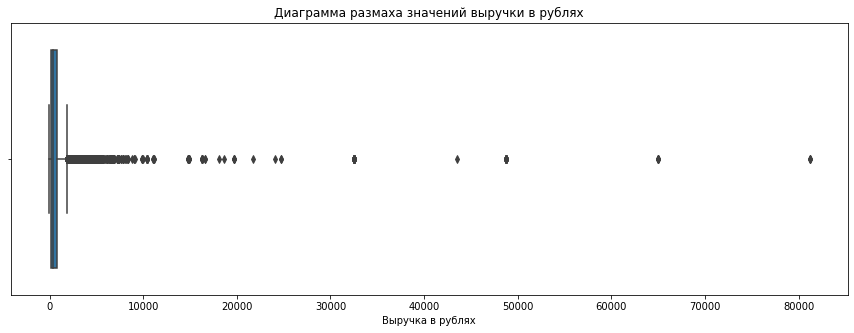

In [35]:
#Визуализация распределений
plt.figure(figsize=(15, 5))  
sns.boxplot(x=df_rub['revenue'])  # Строим boxplot
plt.title('Диаграмма размаха значений выручки в рублях')
plt.xlabel('Выручка в рублях')
plt.show()

Медиана: 347 рублей — типичная стоимость билета  
Среднее: 548 рублей — выше медианы из-за влияния дорогих билетов  
Диапазон: основные покупки (50% данных) составляют 114–793 рубля    
Особенности: наличие отрицательных значений (-91 рубль) указывает на возвраты




Отфильтруем датасет от отрицательных значений и по 99 процентилю.

In [36]:

# Отфильтруем отрицательные значения
df_filtered_rub = df_rub[df_rub['revenue'] > 0]

# Вычислим 99-й процентиль
percentile_99 = df_filtered_rub['revenue'].quantile(0.99)

# Отфильтруем значения, превышающие 99-й процентиль
df_filtered_rub = df_filtered_rub[df_filtered_rub['revenue'] <= percentile_99]
df_filtered_rub['revenue'].describe()

count    276816.000000
mean        521.747925
std         500.658203
min           0.020000
25%         123.459999
50%         355.399994
75%         788.900024
max        2574.320068
Name: revenue, dtype: float64

Данные более равномерные, теперь построим диаграмму распределения значений.

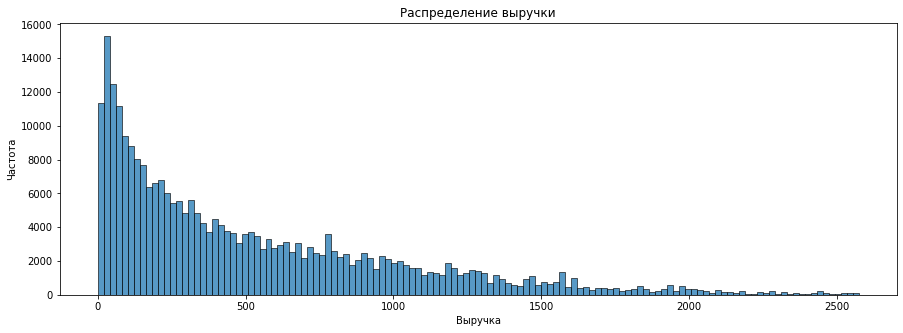

In [37]:
# Диаграмма распределения значений

plt.figure(figsize=(15, 5))  
sns.histplot(df_filtered_rub['revenue'] )  # Строим гистограмму с линией плотности
plt.title('Распределение выручки')
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.show()


Большинство заказов имеют небольшую выручку, а редкие — очень высокую.

In [38]:
#Проверим распределение выручки в тенге
df_kzt=df[df['currency_code']=='kzt']
df_kzt['revenue'].describe()

count     5069.000000
mean      4995.207031
std       4916.752930
min          0.000000
25%        518.099976
50%       3698.830078
75%       7397.660156
max      26425.859375
Name: revenue, dtype: float64

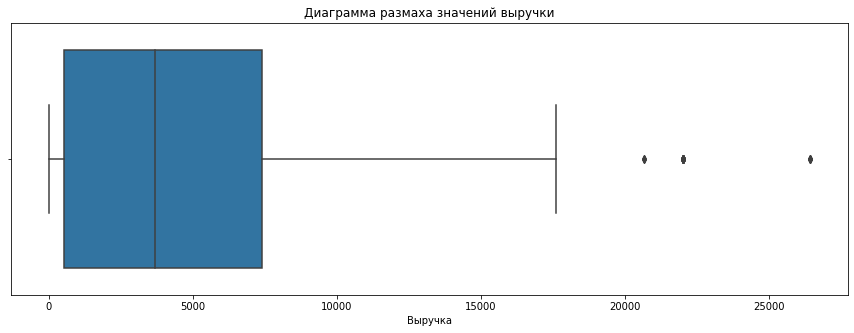

In [39]:
plt.figure(figsize=(15, 5))  
sns.boxplot(x=df_kzt['revenue'])  # Строим boxplot
plt.title('Диаграмма размаха значений выручки')
plt.xlabel('Выручка')
plt.show()

- Конвертированная выручка в тенге в среднем вдвое выше рублевой
- Диапазон значений более узкий
- Отрицательных сумм нет - фильтруем только выбросы

In [40]:
# Вычислим 99-й процентиль
percentile_99_kzt = df_kzt['revenue'].quantile(0.99)

# Отфильтруем значения, превышающие 99-й процентиль
df_filtered_kzt = df_kzt[df_kzt['revenue'] <= percentile_99]
df_filtered_kzt['revenue'].describe()

count    2100.000000
mean      703.690308
std       656.641541
min         0.000000
25%       251.229996
50%       410.579987
75%       933.524979
max      2367.760010
Name: revenue, dtype: float64

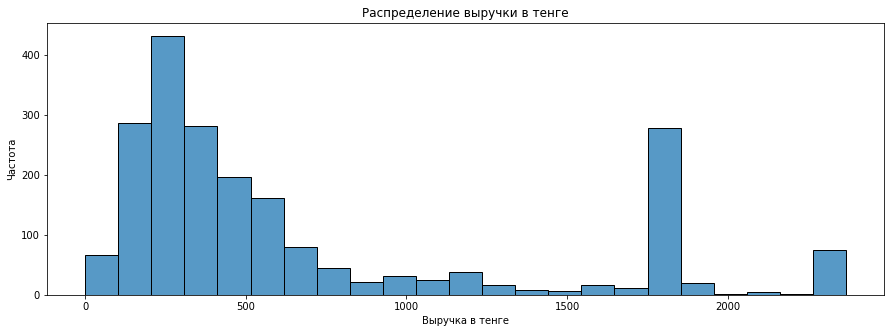

In [41]:
plt.figure(figsize=(15, 5))   
sns.histplot(df_filtered_kzt['revenue'])   
plt.title('Распределение выручки в тенге')
plt.xlabel('Выручка в тенге')
plt.ylabel('Частота')
plt.show()

In [42]:
# Объединение данных после фильтрации выбросов
df_union = pd.concat([df_filtered_rub, df_filtered_kzt])
print("Информация об объединенном датасете:")
df_union.info()

Информация об объединенном датасете:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 278916 entries, 0 to 290724
Data columns (total 32 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                278916 non-null  int32         
 1   user_id                 278916 non-null  object        
 2   created_dt_msk          278916 non-null  datetime64[ns]
 3   created_ts_msk          278916 non-null  datetime64[ns]
 4   event_id                278916 non-null  int32         
 5   cinema_circuit          278916 non-null  object        
 6   age_limit               278916 non-null  int8          
 7   currency_code           278916 non-null  object        
 8   device_type_canonical   278916 non-null  object        
 9   revenue                 278916 non-null  float32       
 10  service_name            278916 non-null  object        
 11  tickets_count           278916 non-null  int8         

In [43]:
# Проверка распределения количества билетов
df_union['tickets_count'].describe()

count    278916.000000
mean          2.743238
std           1.158953
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          47.000000
Name: tickets_count, dtype: float64

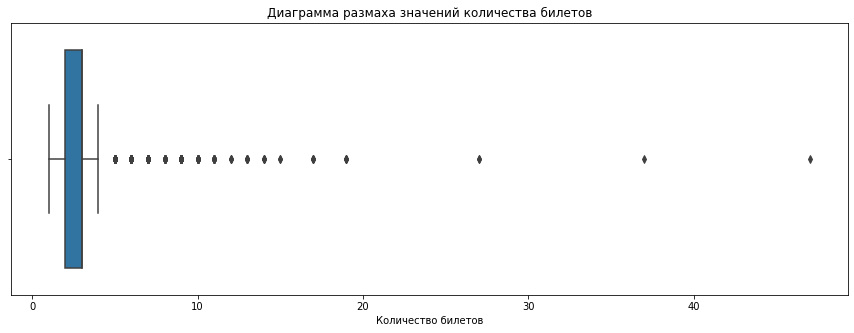

In [44]:
plt.figure(figsize=(15, 5))   
sns.boxplot(x=df_union['tickets_count'])   
plt.title('Диаграмма размаха значений количества билетов')
plt.xlabel('Количество билетов')
plt.show()


Основная масса заказов — 2-3 билета. Аномальные значения удалим по 99-му процентилю.


In [45]:
# Удаление выбросов по 99% процентилю
ticket_threshold = df_union['tickets_count'].quantile(0.99)
df_filtered = df_union[df_union['tickets_count'] <= ticket_threshold]
df_filtered['tickets_count'].describe()

count    278742.000000
mean          2.738780
std           1.139167
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           6.000000
Name: tickets_count, dtype: float64

Фильтрация выбросов не изменила средние значения - большинство заказов по-прежнему составляют 2-3 билета

In [46]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278742 entries, 0 to 290724
Data columns (total 32 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                278742 non-null  int32         
 1   user_id                 278742 non-null  object        
 2   created_dt_msk          278742 non-null  datetime64[ns]
 3   created_ts_msk          278742 non-null  datetime64[ns]
 4   event_id                278742 non-null  int32         
 5   cinema_circuit          278742 non-null  object        
 6   age_limit               278742 non-null  int8          
 7   currency_code           278742 non-null  object        
 8   device_type_canonical   278742 non-null  object        
 9   revenue                 278742 non-null  float32       
 10  service_name            278742 non-null  object        
 11  tickets_count           278742 non-null  int8          
 12  total                   278742

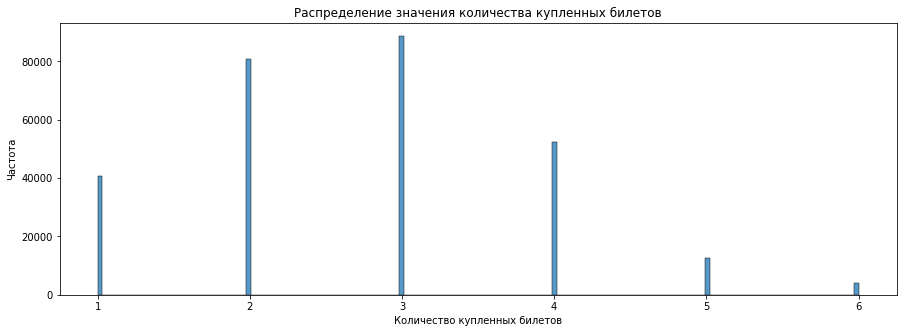

In [47]:
plt.figure(figsize=(15, 5))   
sns.histplot(df_filtered['tickets_count'])   
plt.title('Распределение значения количества купленных билетов')
plt.xlabel('Количество купленных билетов')
plt.ylabel('Частота')
plt.show()

По гистограмме видим, что чаще всего пользователи покупают 2-3 билета, что достаточно логичто 

In [48]:
# Процент оставшихся данных после очистки
remaining_percent = round(df_filtered['order_id'].count() / three_df['order_id'].count(), 2)
remaining_percent

0.96

Результаты предобработки данных:

После очистки данных объем датасета сократился. Удалено примерно 4% записей, включая:
- Выбросы
- Неявные дубликаты
- Заказы без информации о типе события

Структура данных:
- Итоговый датафрейм содержит 32 столбца
- Итоговый датафрейм содержит 278742 строк
- Добавлены 4 новых признака:
    - revenue_rub — выручка в рублях
    - one_ticket_revenue_rub — стоимость одного билета
    - month — месяц заказа
    - season — сезон (лето,осень, зима, весна)

Выполненные операции:
- Корректировка типов данных
- Оптимизация разрядности
- Обработка пропусков

Датасет df_filtered готов для дальнейшего анализа.

### Шаг 3. Исследовательский анализ данных

#### 3.1. Анализ распределения заказов по сегментам и их сезонные изменения

In [49]:
# Агрегация заказов по месяцам
monthly_orders = df_filtered.groupby('month')['order_id'].count().reset_index()
monthly_orders

,month,order_id
0,6,30721
1,7,37666
2,8,42887
3,9,68687
4,10,98781


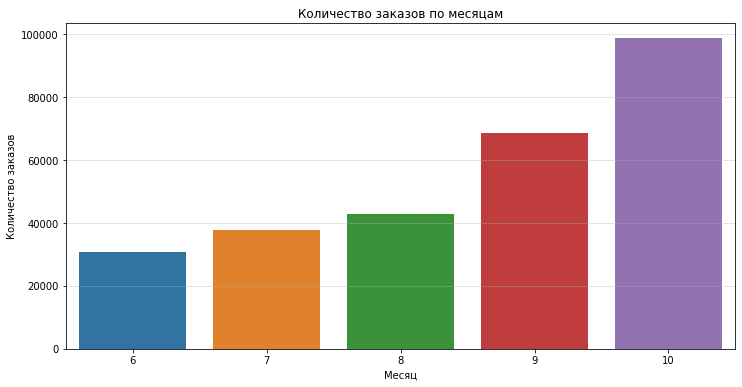

In [50]:
# Сначала создаем группировку по месяцам
group_month = df_filtered.groupby('month')['order_id'].count().reset_index()

# Затем строим график
plt.figure(figsize=(12,6))
sns.barplot(x='month', y='order_id', data=group_month)
plt.title('Количество заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

Наблюдается устойчивый рост количества заказов с пиковыми значениями в сентябре и октябре. Сентябрь показал резкий рост примерно на 60% по сравнению с августом — с 43 тысяч до 69 тысяч заказов. Октябрь продолжил эту динамику, установив абсолютный рекорд почти  99 тысяч заказов.

Сравнительный анализ сезонных паттернов

Сопоставим распределение заказов между летним и осенним периодами по ключевым категориям:
- Типы мероприятий
- Устройства оформления заказов
- Возрастные рейтинги мероприятий

In [51]:
# Шаг 1. Сгруппируем заказы по сезону. Посчитаем кол-во заказов.
total_season= df_filtered.groupby('season')['order_id'].count().reset_index(name='total_in_season')
total_season

,season,total_in_season
0,лето,111274
1,осень,167468


In [52]:
# Шаг 2. Сгруппируем по сезону и по типу мероприятия

count_event_type= df_filtered.groupby(['season','event_type_main'])['order_id'].count().reset_index(name='count')

# Шаг 3. Объединяем count_event_type и total_season для расчета доли
grp_event_type = pd.merge(count_event_type, total_season, on='season')

# Шаг 4. Считаем долю
grp_event_type['proportion']= grp_event_type['count']/grp_event_type['total_in_season']
grp_event_type


,season,event_type_main,count,total_in_season,proportion
0,лето,выставки,2407,111274,0.021631
1,лето,другое,28356,111274,0.254830
2,лето,концерты,47447,111274,0.426398
3,лето,спорт,2758,111274,0.024786
4,лето,стендап,6343,111274,0.057003
5,лето,театр,23690,111274,0.212898
6,лето,ёлки,273,111274,0.002453
7,осень,выставки,2402,167468,0.014343
8,осень,другое,32577,167468,0.194527
9,осень,концерты,62411,167468,0.372674


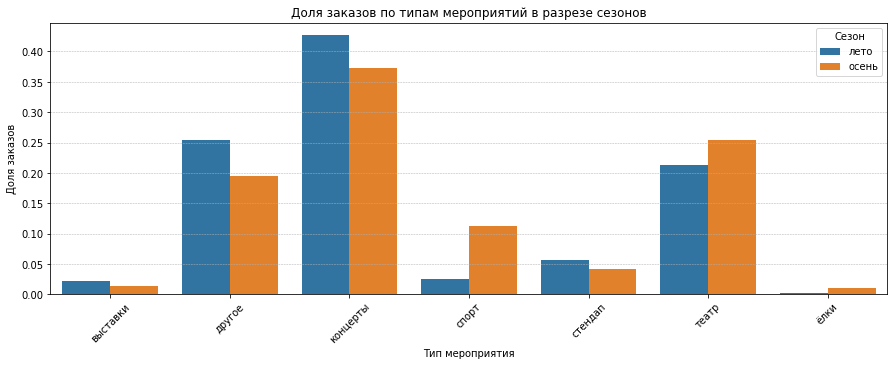

In [53]:
# Сначала создаем таблицу с долями заказов по типам мероприятий и сезонам
grp_event_type = (df_filtered.groupby(['season', 'event_type_main'])['order_id']
                  .count()
                  .reset_index()
                  .rename(columns={'order_id': 'count'}))

# Рассчитываем доли для каждого сезона
total_orders_by_season = grp_event_type.groupby('season')['count'].transform('sum')
grp_event_type['proportion'] = grp_event_type['count'] / total_orders_by_season

# Затем строим график
plt.figure(figsize=(15, 5))
sns.barplot(x='event_type_main', y='proportion', hue='season', data=grp_event_type)
plt.title('Доля заказов по типам мероприятий в разрезе сезонов')
plt.xlabel('Тип мероприятия')
plt.ylabel('Доля заказов')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.legend(title='Сезон')
plt.xticks(rotation=45)
plt.show()

Летом популярны мероприятия на открытом воздухе — концерты под открытым небом, выставки, которые активно посещают туристы.

Осенью пользователи переключаются на мероприятия в помещениях: театры, городские события. Также начинается подготовка к зимним праздникам — растут продажи билетов на ёлки. Спортивные мероприятия традиционно стартуют в осенний сезон.

Данная динамика отражает естественную смену развлекательных форматов в зависимости от времени года и погодных условий.

In [54]:
#Шаг 5. Анализ распределения заказов по устройствам в разрезе сезонов
device_by_season = (df_filtered.groupby(['season', 'device_type_canonical'])['order_id']
                    .count()
                    .reset_index(name='orders_count'))

#Шаг 6. Добавление общего количества заказов по сезонам
device_by_season = device_by_season.merge(total_season, on='season')

#Шаг 7. Расчет процентного соотношения
device_by_season['share'] = device_by_season['orders_count'] / device_by_season['total_in_season']

device_by_season

,season,device_type_canonical,orders_count,total_in_season,share
0,лето,desktop,20853,111274,0.187402
1,лето,mobile,90421,111274,0.812598
2,осень,desktop,34111,167468,0.203687
3,осень,mobile,133357,167468,0.796313


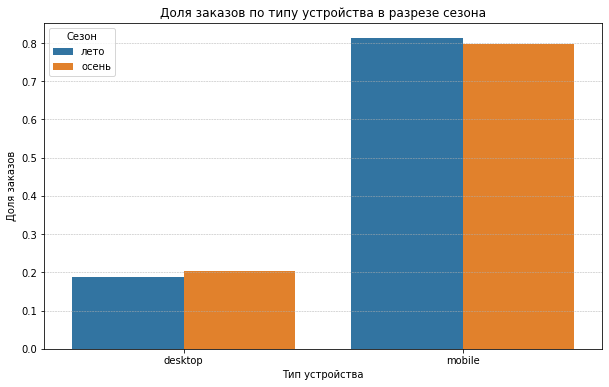

In [55]:
# Сначала создаем таблицу с общим количеством заказов по сезонам
total_season = df_filtered.groupby('season')['order_id'].count().reset_index(name='total_in_season')

# Группируем по сезону и типу устройства
count_device_type = df_filtered.groupby(['season', 'device_type_canonical'])['order_id'].count().reset_index(name='count')

# Объединяем для расчета долей
grp_device_type = pd.merge(count_device_type, total_season, on='season')

# Считаем долю заказов
grp_device_type['proportion'] = grp_device_type['count'] / grp_device_type['total_in_season']

# Строим график
plt.figure(figsize=(10,6))
sns.barplot(x='device_type_canonical', y='proportion', hue='season', data=grp_device_type)
plt.title('Доля заказов по типу устройства в разрезе сезона')
plt.xlabel('Тип устройства')
plt.ylabel('Доля заказов')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.legend(title='Сезон')
plt.show()

Доля заказов в разрезе типов устройств по сезонам, практически не изменилась, но рост доли десктопных заказов может быть связан с возвращением пользователей к рабочему ритму после летнего периода. В офисной среде пользователям удобнее оформлять билеты со стационарных компьютеров.

,Лето,Осень
0,18.6,23.4
6,18.8,17.7
12,20.5,22.1
16,28.0,26.3
18,14.2,10.4


<Figure size 1080x360 with 0 Axes>

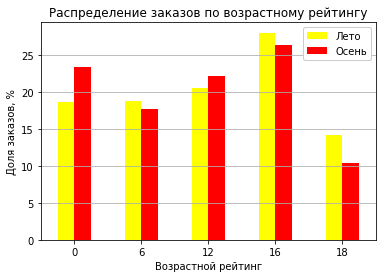


Детальная статистика по возрастным рейтингам:


,season,age_limit,count,total_in_season,proportion
0,лето,0,20649,111274,0.185569
1,лето,6,20878,111274,0.187627
2,лето,12,22806,111274,0.204954
3,лето,16,31195,111274,0.280344
4,лето,18,15746,111274,0.141507
5,осень,0,39256,167468,0.234409
6,осень,6,29620,167468,0.176870
7,осень,12,37005,167468,0.220968
8,осень,16,44097,167468,0.263316
9,осень,18,17490,167468,0.104438


In [56]:
# Шаг 8. Анализ возрастного рейтинга:

# Сначала создаем выборки по сезонам
summer = df_filtered[df_filtered['season'] == 'лето']
autumn = df_filtered[df_filtered['season'] == 'осень']

# Подготовка данных для графика
age_summer = summer['age_limit'].value_counts(normalize=True).mul(100).round(1)
age_autumn = autumn['age_limit'].value_counts(normalize=True).mul(100).round(1)
ages_comparison = pd.DataFrame({'Лето': age_summer, 'Осень': age_autumn})

# Отображение таблицы
display(ages_comparison)

# Построение графика
plt.figure(figsize=(15, 5))
ages_comparison.plot(kind='bar', color=['yellow', 'red'])
plt.title('Распределение заказов по возрастному рейтингу')
plt.xlabel('Возрастной рейтинг')
plt.ylabel('Доля заказов, %')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(framealpha=1)
plt.show()

# Дополнительная статистика
count_age_limit = df_filtered.groupby(['season', 'age_limit'])['order_id'].count().reset_index(name='count')
grp_age_limit = pd.merge(count_age_limit, total_season, on='season')
grp_age_limit['proportion'] = grp_age_limit['count'] / grp_age_limit['total_in_season']

print("\nДетальная статистика по возрастным рейтингам:")
display(grp_age_limit)

Анализ возрастной динамики по сезонам:

Осень vs Лето:  
Рост: 0+ (+4.8 п.п.), 12+ (+1.6 п.п.) - подготовка к школе  
Снижение: 18+ (-3.8 п.п.), 6+ (-1.1 п.п.)  
Стабильно высокие: 16+ (28% → 26.3%)  

Вывод: Летом активнее взрослые (16+), осенью — дети и подростки (0+, 12+).

In [57]:
# Анализ динамики стоимости билетов по типам мероприятий и сезонам
# Стоимость билетов по типам событий и сезонам (по убыванию)
price_by_season = (df_filtered.groupby(['season', 'event_type_main'])['one_ticket_revenue_rub']
                   .mean()
                   .reset_index()
                   .sort_values('one_ticket_revenue_rub', ascending=False))

price_by_season

,season,event_type_main,one_ticket_revenue_rub
2,лето,концерты,295.152893
6,лето,ёлки,271.436188
9,осень,концерты,267.614349
11,осень,стендап,231.124969
13,осень,ёлки,229.936127
4,лето,стендап,218.484283
5,лето,театр,216.397858
12,осень,театр,176.091171
7,осень,выставки,91.905090
1,лето,другое,87.329300


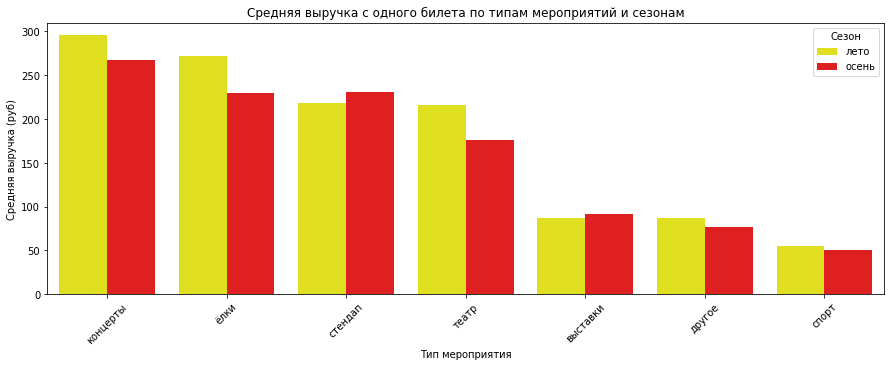

In [58]:
# Сначала создаем данные для графика
mean_event_type = (df_filtered.groupby(['season', 'event_type_main'])['one_ticket_revenue_rub']
                   .mean()
                   .reset_index(name='mean')
                   .sort_values('mean', ascending=False))

# Строим график с измененными цветами
plt.figure(figsize=(15, 5))
sns.barplot(x='event_type_main', y='mean', hue='season', data=mean_event_type, 
            palette=['yellow', 'red'])  # Желтый для лета, красный для осени
plt.title('Средняя выручка с одного билета по типам мероприятий и сезонам')
plt.xlabel('Тип мероприятия')
plt.ylabel('Средняя выручка (руб)')
plt.legend(title='Сезон')
plt.xticks(rotation=45)
plt.show()

Осенью рост средней стоимости наблюдается только в двух категориях:  
Стендап и выставки — незначительное увеличение

В пяти категориях зафиксировано снижение выручки:   
Театр, ёлки, концерты, спорт, другие мероприятия

Премиальный сегмент (свыше 200 руб./билет) сохраняется за концертами, ёлками, стендапом  в оба сезона и театром летом.

season,лето,осень,difference
event_type_main,,,
выставки,86.744476,91.905090,5.949214
другое,87.329300,77.201889,-11.596807
концерты,295.152893,267.614349,-9.330264
спорт,55.195580,50.250080,-8.959956
стендап,218.484283,231.124969,5.785627
театр,216.397858,176.091171,-18.626196
ёлки,271.436188,229.936127,-15.289066


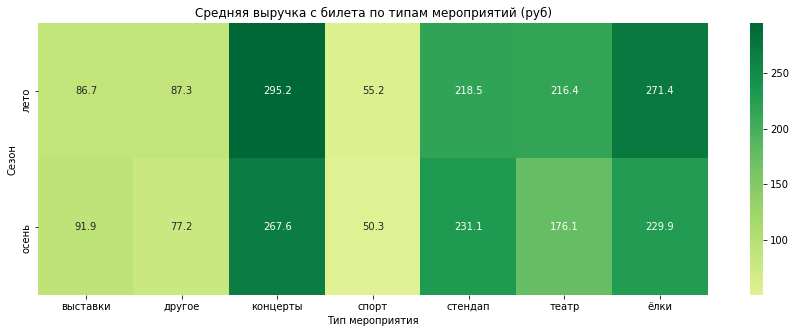

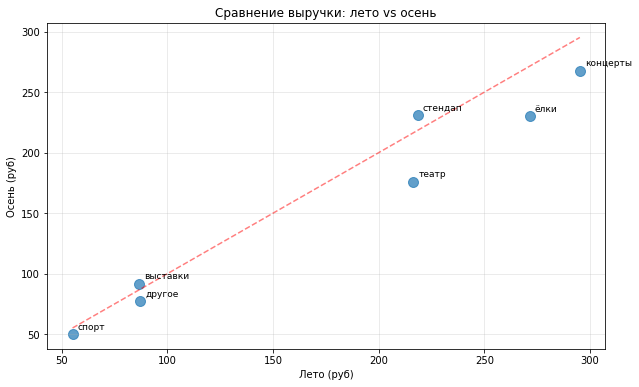

In [59]:
# Создание сводной таблицы для расчета относительного изменения выручки
pivot_table = mean_event_type.pivot_table(index='event_type_main', columns='season', values='mean')

# Расчет относительного изменения (изменение в процентах)
pivot_table['difference'] = ((pivot_table['осень'] - pivot_table['лето']) / pivot_table['лето']) * 100

# Отображаем таблицу
display(pivot_table)

# Тепловая карта изменений
plt.figure(figsize=(15, 5))
heatmap_data = pivot_table[['лето', 'осень']]
sns.heatmap(heatmap_data.T, annot=True, fmt='.1f', cmap='RdYlGn', center=0)
plt.title('Средняя выручка с билета по типам мероприятий (руб)')
plt.xlabel('Тип мероприятия')
plt.ylabel('Сезон')
plt.show()

# Точечная диаграмма сравнения сезонов
plt.figure(figsize=(10, 6))
plt.scatter(pivot_table['лето'], pivot_table['осень'], s=100, alpha=0.7)
plt.plot([pivot_table['лето'].min(), pivot_table['лето'].max()], 
         [pivot_table['лето'].min(), pivot_table['лето'].max()], 'r--', alpha=0.5)
plt.xlabel('Лето (руб)')
plt.ylabel('Осень (руб)')
plt.title('Сравнение выручки: лето vs осень')
for i, event_type in enumerate(pivot_table.index):
    plt.annotate(event_type, (pivot_table['лето'].iloc[i], pivot_table['осень'].iloc[i]), 
                 xytext=(5, 5), textcoords='offset points', fontsize=9)
plt.grid(True, alpha=0.3)
plt.show()

Динамика заказов:
- Наблюдается стабильный месячный рост с пиковыми значениями осенью
- Сентябрь показал резкий рост на 60% после августа, октябрь достиг пика почти 99 тысяч заказов
- Активизация связана с завершением летнего сезона отпусков и каникул

Сезонные изменения в структуре спроса:
- Рост осенью: спорт, театры, новогодние ёлки
- Снижение осенью: концерты, стендап, выставки, прочие мероприятия
- Смена предпочтений объясняется переходом от летних мероприятий на открытом воздухе к осенним событиям в помещениях

Технические аспекты:
- Незначительный рост доли заказов с ПК (+2%) за счет возвращения к рабочему ритму
- Увеличение спроса на детские мероприятия (0+ и 12+)

Финансовые показатели:
- Снижение средней выручки с билета осенью в большинстве категорий
- Рост стоимости сохранился только для выставок и стендапа

#### 3.2. Осенняя активность пользователей

In [60]:
# Фильтрация данных за осень 2024 года
df_autumn = df_filtered[(df_filtered['season'] == 'осень')]

# Сгруппируем отфильтрованные данные по дням и посчитаем метрики
grp_autumn = df_autumn.groupby('created_dt_msk').agg(
    total_orders=('order_id', 'count'),
    dau=('user_id', 'nunique'),
    total_revenue=('revenue_rub', 'sum'),
    total_tickets=('tickets_count', 'sum')
).reset_index()

# Расчет дополнительных метрик
grp_autumn['orders_per_user'] = grp_autumn['total_orders'] / grp_autumn['dau']
grp_autumn['avg_ticket_price'] = grp_autumn['total_revenue'] / grp_autumn['total_tickets']

# Отображаем первые строки
display(grp_autumn.head())



,created_dt_msk,total_orders,dau,total_revenue,total_tickets,orders_per_user,avg_ticket_price
0,2024-09-01,1314,555,7.262059e+05,3683.0,2.367568,197.177827
1,2024-09-02,1356,565,6.890416e+05,3647.0,2.400000,188.933798
2,2024-09-03,5078,770,1.143540e+06,15206.0,6.594805,75.203226
3,2024-09-04,1746,680,8.475783e+05,4732.0,2.567647,179.116296
4,2024-09-05,1912,730,9.657408e+05,5107.0,2.619178,189.101393


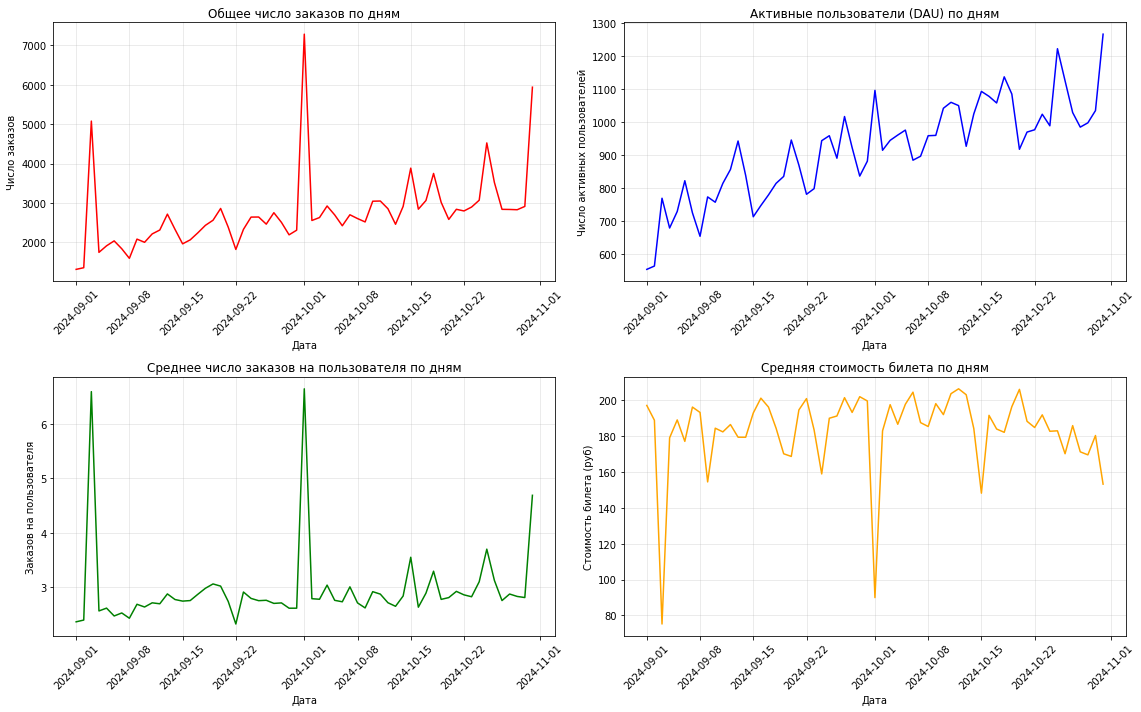

In [61]:
# Визуализация динамики по дням
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

# Общее число заказов
sns.lineplot(ax=axes[0, 0], x='created_dt_msk', y='total_orders', data=grp_autumn, color='red')
axes[0, 0].set_title('Общее число заказов по дням')
axes[0, 0].set_xlabel('Дата')
axes[0, 0].set_ylabel('Число заказов')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# DAU
sns.lineplot(ax=axes[0, 1], x='created_dt_msk', y='dau', data=grp_autumn, color='blue')
axes[0, 1].set_title('Активные пользователи (DAU) по дням')
axes[0, 1].set_xlabel('Дата')
axes[0, 1].set_ylabel('Число активных пользователей')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Среднее число заказов на одного пользователя
sns.lineplot(ax=axes[1, 0], x='created_dt_msk', y='orders_per_user', data=grp_autumn, color='green')
axes[1, 0].set_title('Среднее число заказов на пользователя по дням')
axes[1, 0].set_xlabel('Дата')
axes[1, 0].set_ylabel('Заказов на пользователя')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Средняя стоимость одного билета
sns.lineplot(ax=axes[1, 1], x='created_dt_msk', y='avg_ticket_price', data=grp_autumn, color='orange')
axes[1, 1].set_title('Средняя стоимость билета по дням')
axes[1, 1].set_xlabel('Дата')
axes[1, 1].set_ylabel('Стоимость билета (руб)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Наблюдается положительный тренд роста активных пользователей (700-1100 DAU) и заказов (обычно 1500-3000 в день). Однако выявлены аномальные пики 2 сентября и 1 октября, когда:
- Цена билета упала с 180 до 80 рублей
- Количество заказов взлетело до 7000+
- Средний чек вырос с 2-3 до 5-6 билетов на пользователя

При этом общая выручка и приток новых пользователей не увеличились significantly. Вероятные причины — агрессивные акции или технические сбои, привлекшие перекупщиков.   
Рекомендуется:
- Исследовать причины резкого снижения цен
- Скорректировать ценовую политику акций
- Насытить ассортимент для стабилизации цен после 15 октября
- Пиковая активность не приносит пропорционального роста выручки, требуя оптимизации маркетинговых стратегий.

Во всех графиках, кроме «Количество активных пользователей», наблюдаются сильные скачки на даты 2024-09-01 и 2024-10-01.

In [62]:
# Создаем копию для безопасного изменения
df_autumn = df_autumn.copy()

# Добавляем столбцы с днем недели и признаком выходного
df_autumn['day_of_week'] = df_autumn['created_dt_msk'].dt.day_name()  
df_autumn['is_weekend'] = df_autumn['created_dt_msk'].dt.dayofweek > 4

# Просмотр результата
print("Добавлены столбцы дня недели и выходных:")
display(df_autumn[['created_dt_msk', 'day_of_week', 'is_weekend']].head())

Добавлены столбцы дня недели и выходных:


,created_dt_msk,day_of_week,is_weekend
2,2024-10-06,Sunday,True
4,2024-10-04,Friday,False
5,2024-10-23,Wednesday,False
7,2024-09-29,Sunday,True
8,2024-10-15,Tuesday,False


In [63]:
# Анализ активности по дням недели
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

grp_week = (df_autumn.groupby('day_of_week')
            .agg(
                total_orders=('order_id', 'count'),
                dau=('user_id', 'nunique')
            )
            .reindex(days_order))

# Расчет среднего количества заказов на пользователя
grp_week['orders_per_user'] = grp_week['total_orders'] / grp_week['dau']

print("Статистика по дням недели:")
display(grp_week)

Статистика по дням недели:


,total_orders,dau,orders_per_user
day_of_week,,,
Monday,21426,4419,4.848608
Tuesday,31359,4769,6.575592
Wednesday,22758,4797,4.744215
Thursday,26991,4943,5.460449
Friday,24610,4822,5.103691
Saturday,21143,4508,4.690106
Sunday,19181,4330,4.429792


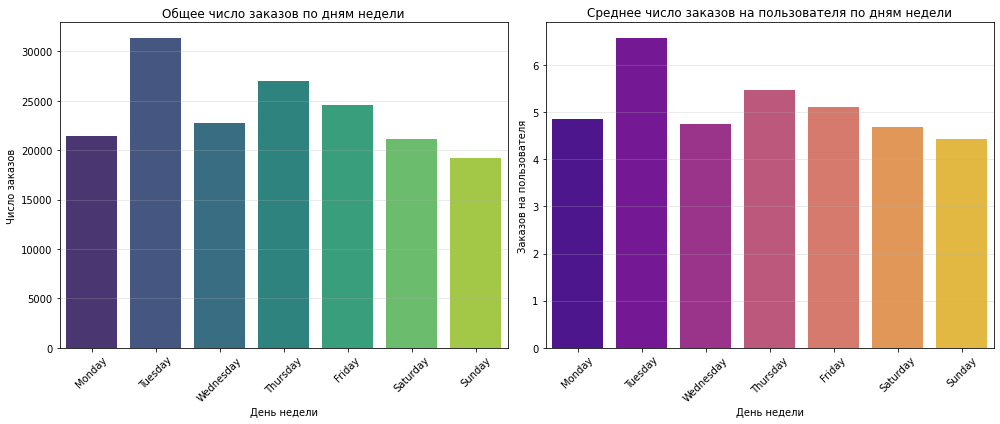

In [64]:
# Визуализация недельной активности
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# График общего числа заказов
sns.barplot(ax=axes[0], x=grp_week.index, y='total_orders', data=grp_week, palette='viridis')
axes[0].set_title('Общее число заказов по дням недели')
axes[0].set_xlabel('День недели')
axes[0].set_ylabel('Число заказов')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# График заказов на пользователя
sns.barplot(ax=axes[1], x=grp_week.index, y='orders_per_user', data=grp_week, palette='plasma')
axes[1].set_title('Среднее число заказов на пользователя по дням недели')
axes[1].set_xlabel('День недели')
axes[1].set_ylabel('Заказов на пользователя')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Наибольшая активность пользователей наблюдается в середине недели — вторник и четверг являются пиковыми днями для покупки билетов. При этом выходные дни показывают значительно меньшую активность.

Статистика по дням недели:


,dau,avg_ticket_price
day_of_week,,
Monday,4419,5897.325684
Tuesday,4769,5020.030762
Wednesday,4797,5895.132324
Thursday,4943,5844.899902
Friday,4822,6152.100586
Saturday,4508,6216.400879
Sunday,4330,6288.356934


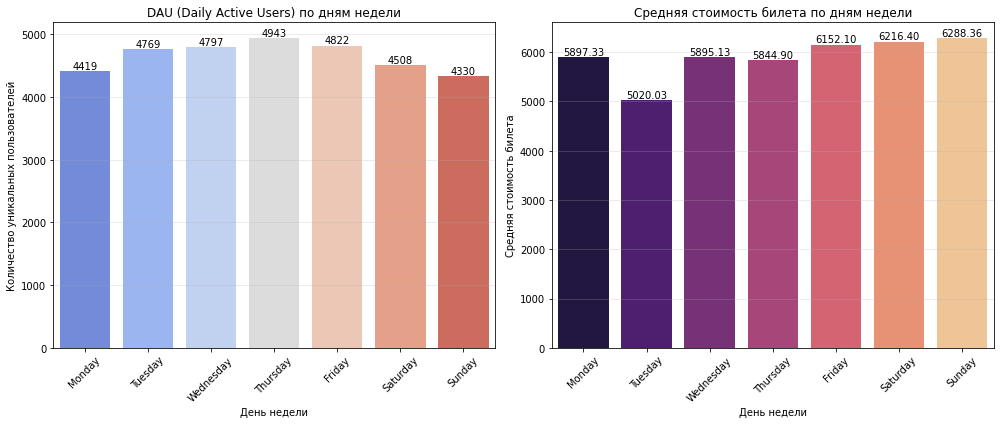

In [65]:
# Анализ активности по дням недели
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

grp_week = (df_autumn.groupby('day_of_week')
            .agg(
                dau=('user_id', 'nunique'),
                avg_ticket_price=('total', 'mean')
            )
            .reindex(days_order))

print("Статистика по дням недели:")
display(grp_week)

# Визуализация DAU и средней стоимости билета по дням недели
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# График DAU по дням недели
sns.barplot(ax=axes[0], x=grp_week.index, y='dau', data=grp_week, palette='coolwarm')
axes[0].set_title('DAU (Daily Active Users) по дням недели')
axes[0].set_xlabel('День недели')
axes[0].set_ylabel('Количество уникальных пользователей')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Добавляем значения на столбцы
for i, value in enumerate(grp_week['dau']):
    axes[0].text(i, value + 0.05, f'{value:.0f}', ha='center', va='bottom')

# График средней стоимости билета по дням недели
sns.barplot(ax=axes[1], x=grp_week.index, y='avg_ticket_price', data=grp_week, palette='magma')
axes[1].set_title('Средняя стоимость билета по дням недели')
axes[1].set_xlabel('День недели')
axes[1].set_ylabel('Средняя стоимость билета')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# Добавляем значения на столбцы
for i, value in enumerate(grp_week['avg_ticket_price']):
    axes[1].text(i, value + 0.05, f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

- Больше всего пользователей в четверг (4943)
- Меньше всего в воскресенье (4330)
- Цены растут к выходным - от 5020₽ во вторник до 6288₽ в воскресенье  

Что это значит:  
В выходные меньше пользователей, но они готовы платить больше. В будни больше пользователей, но со средними чеками. Четверг - лучший день по охвату, воскресенье - по деньгам.

In [66]:
# Сравнение пользовательской активности в будни и выходные
weekend_vs_weekday = df_autumn.groupby('is_weekend').agg(
    total_orders=('order_id', 'count'),
    dau=('user_id', 'nunique')
)

# Расчет среднего количества заказов на пользователя
weekend_vs_weekday['orders_per_user'] = weekend_vs_weekday['total_orders'] / weekend_vs_weekday['dau']

# Переименовываем индексы для читаемости
weekend_vs_weekday.index = ['Будни', 'Выходные']

print("Сравнение активности в будни и выходные:")
display(weekend_vs_weekday)

Сравнение активности в будни и выходные:


,total_orders,dau,orders_per_user
Будни,127144,13138,9.677576
Выходные,40324,7049,5.720528


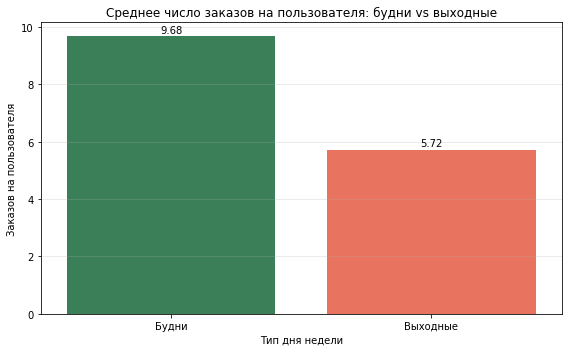

In [67]:
# Визуализация активности в будни и выходные
plt.figure(figsize=(8, 5))
sns.barplot(x=weekend_vs_weekday.index, y='orders_per_user', data=weekend_vs_weekday, 
            palette=['#2E8B57', '#FF6347'])  # Зеленый для будней, красный для выходных
plt.title('Среднее число заказов на пользователя: будни vs выходные')
plt.xlabel('Тип дня недели')
plt.ylabel('Заказов на пользователя')
plt.grid(axis='y', alpha=0.3)

# Добавляем значения на столбцы
for i, value in enumerate(weekend_vs_weekday['orders_per_user']):
    plt.text(i, value + 0.05, f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Пользователи демонстрируют более высокую активность в будние дни — среднее количество заказов на человека превышает показатели выходных. Наибольшая активность сосредоточена в середине недели.

 

#### 3.3. Популярные события и партнёры

In [68]:
# Агрегация данных по регионам
grp_region = df_autumn.groupby('region_name').agg(
    unique_events=('event_id', 'nunique'),
    total_orders=('order_id', 'count')
).reset_index().sort_values('total_orders', ascending=False)

print("Топ-15 регионов по заказам:")
display(grp_region.head(15))

Топ-15 регионов по заказам:


,region_name,unique_events,total_orders
23,Каменевский регион,3894,46560
59,Североярская область,2594,20563
41,Медовская область,361,12034
75,Широковская область,794,8645
44,Озернинский край,296,7524
56,Светополянский округ,755,4751
60,Серебринская область,456,4467
40,Малиновоярский округ,137,4412
76,Яблоневская область,431,4195
63,Солнечноземская область,401,4193


In [69]:
# Расчет долей рынка
total_events = grp_region['unique_events'].sum()
total_orders = grp_region['total_orders'].sum()

grp_region['event_share'] = (grp_region['unique_events'] / total_events * 100).round(2)
grp_region['order_share'] = (grp_region['total_orders'] / total_orders * 100).round(2)

print("Топ-10 регионов с долями рынка:")
display(grp_region.head(10))

Топ-10 регионов с долями рынка:


,region_name,unique_events,total_orders,event_share,order_share
23,Каменевский регион,3894,46560,24.70,27.80
59,Североярская область,2594,20563,16.45,12.28
41,Медовская область,361,12034,2.29,7.19
75,Широковская область,794,8645,5.04,5.16
44,Озернинский край,296,7524,1.88,4.49
56,Светополянский округ,755,4751,4.79,2.84
60,Серебринская область,456,4467,2.89,2.67
40,Малиновоярский округ,137,4412,0.87,2.63
76,Яблоневская область,431,4195,2.73,2.50
63,Солнечноземская область,401,4193,2.54,2.50


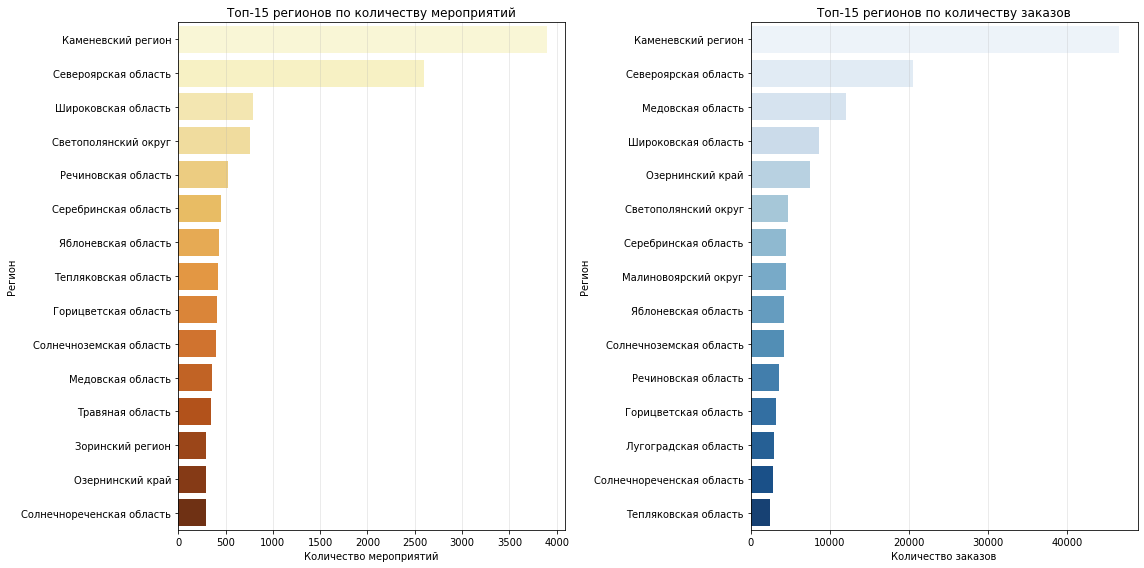

In [70]:
# Визуализация региональной статистики
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# График количества мероприятий
top_events = grp_region.nlargest(15, 'unique_events')
sns.barplot(ax=axes[0], x='unique_events', y='region_name', data=top_events, palette='YlOrBr')
axes[0].set_title('Топ-15 регионов по количеству мероприятий')
axes[0].set_ylabel('Регион')
axes[0].set_xlabel('Количество мероприятий')
axes[0].grid(axis='x', alpha=0.3)

# График количества заказов
top_orders = grp_region.nlargest(15, 'total_orders')
sns.barplot(ax=axes[1], x='total_orders', y='region_name', data=top_orders, palette='Blues')
axes[1].set_title('Топ-15 регионов по количеству заказов')
axes[1].set_ylabel('Регион')
axes[1].set_xlabel('Количество заказов')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

Топ-3 региона по заказам:
- Каменевский регион - 85 373 заказа (абсолютный лидер)
- Североярская область - 43 474 заказа
- Широковская область - 16 082 заказа

Неравномерность эффективности мероприятий:
- Медовская область: всего 462 события - 13 583 заказа (высокая эффективность)
- Светополянский округ: 1 059 событий - 7 463 заказа (низкая эффективность)


Вывод: коммерческая эффективность регионов не зависит напрямую от количества проводимых мероприятий. Ключевыми являются факторы аудитории, популярности площадок и маркетинговой стратегии.

In [71]:
# Исследуем деятельность партнеров по трем ключевым показателям
# Агрегация данных по билетным партнерам
grp_partner = df_autumn.groupby('service_name').agg(
    unique_events=('event_id', 'nunique'),
    total_orders=('order_id', 'count'),
    total_revenue=('revenue_rub', 'sum')
).reset_index().sort_values('total_revenue', ascending=False)

print("Топ партнеров по выручке:")
display(grp_partner.head(10))

Топ партнеров по выручке:


,service_name,unique_events,total_orders,total_revenue
3,Билеты без проблем,2817,31773,11874530.00
24,Мой билет,1000,19258,10675898.00
25,Облачко,1409,15478,10611052.00
21,Лови билет!,3584,25707,10383710.00
8,Весь в билетах,600,9418,9356427.00
5,Билеты в руки,2445,25535,7611673.00
19,Край билетов,193,2996,3016152.25
34,Яблоко,537,3473,2763332.25
26,Прачечная,728,5798,2548310.50
30,Тебе билет!,858,3759,2166184.75


In [72]:
# Расчет долей рынка
total_events = grp_partner['unique_events'].sum()
total_orders = grp_partner['total_orders'].sum()
total_revenue = grp_partner['total_revenue'].sum()

grp_partner['event_share'] = (grp_partner['unique_events'] / total_events * 100).round(2)
grp_partner['order_share'] = (grp_partner['total_orders'] / total_orders * 100).round(2)
grp_partner['revenue_share'] = (grp_partner['total_revenue'] / total_revenue * 100).round(2)

# Форматируем выручку для читаемости
grp_partner['total_revenue_formatted'] = grp_partner['total_revenue'].round().astype(int).apply(lambda x: f"{x:,} руб".replace(",", " "))

print("Партнеры с долями рынка:")
display(grp_partner[['service_name', 'unique_events', 'total_orders', 'total_revenue_formatted', 
                     'event_share', 'order_share', 'revenue_share']].head(15))

Партнеры с долями рынка:


,service_name,unique_events,total_orders,total_revenue_formatted,event_share,order_share,revenue_share
3,Билеты без проблем,2817,31773,11 874 530 руб,16.39,18.97,14.58
24,Мой билет,1000,19258,10 675 898 руб,5.82,11.50,13.11
25,Облачко,1409,15478,10 611 052 руб,8.20,9.24,13.03
21,Лови билет!,3584,25707,10 383 710 руб,20.85,15.35,12.75
8,Весь в билетах,600,9418,9 356 427 руб,3.49,5.62,11.49
5,Билеты в руки,2445,25535,7 611 673 руб,14.23,15.25,9.35
19,Край билетов,193,2996,3 016 152 руб,1.12,1.79,3.70
34,Яблоко,537,3473,2 763 332 руб,3.12,2.07,3.39
26,Прачечная,728,5798,2 548 310 руб,4.24,3.46,3.13
30,Тебе билет!,858,3759,2 166 185 руб,4.99,2.24,2.66


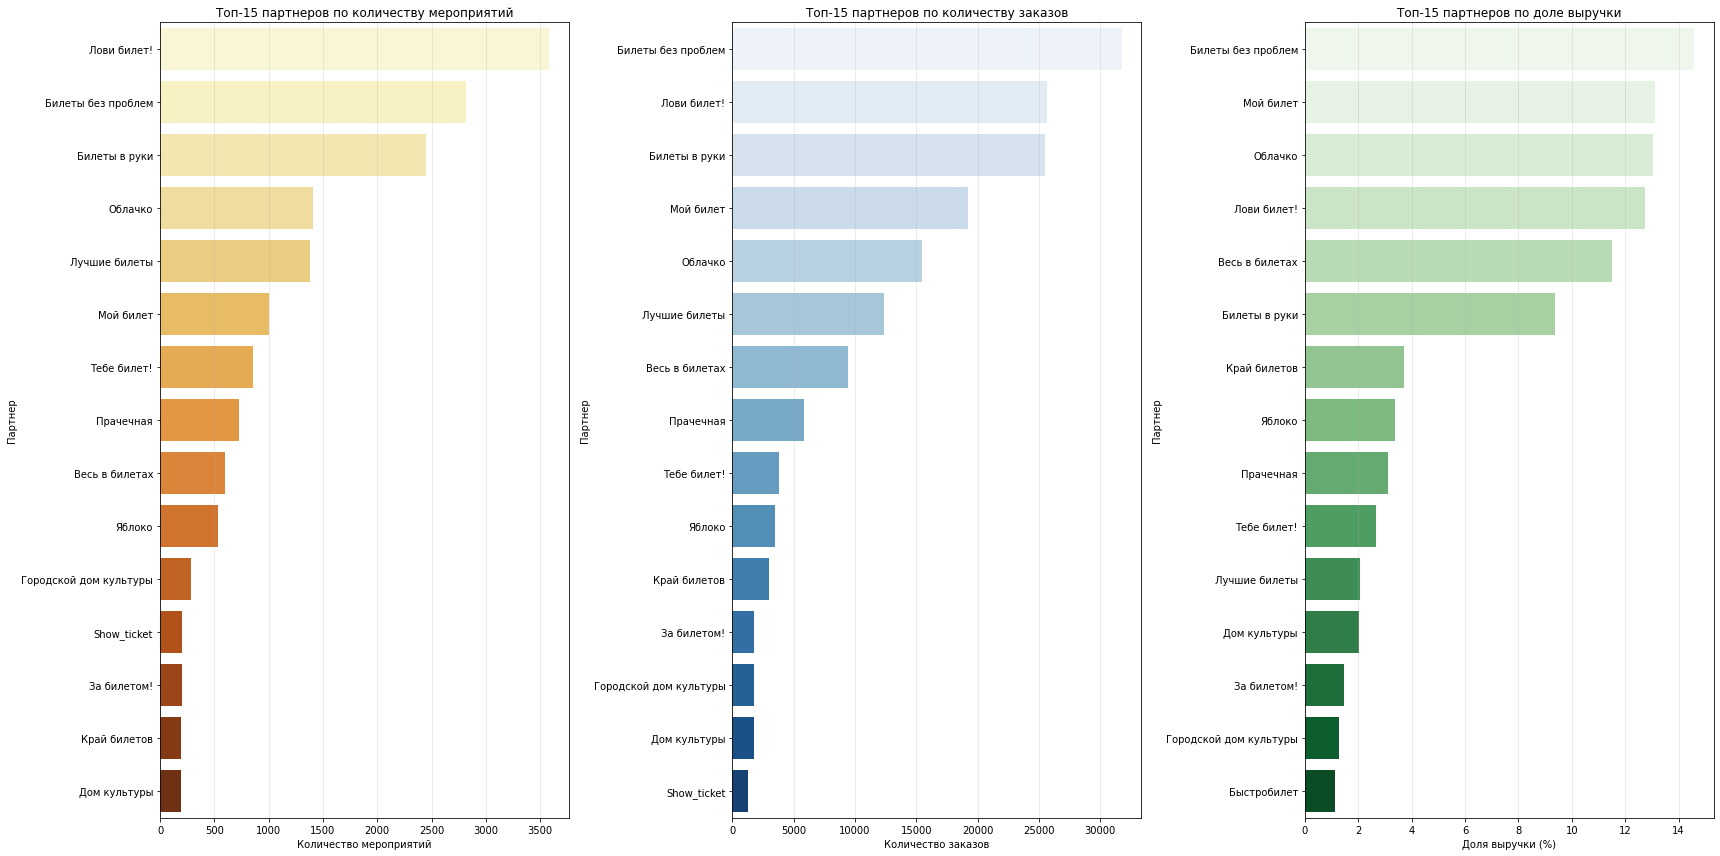

In [73]:
# Визуализация статистики по партнерам
fig, axes = plt.subplots(1, 3, figsize=(24, 12))

# Топ-15 по количеству мероприятий
top_events = grp_partner.nlargest(15, 'unique_events')
sns.barplot(ax=axes[0], x='unique_events', y='service_name', data=top_events, palette='YlOrBr')
axes[0].set_title('Топ-15 партнеров по количеству мероприятий')
axes[0].set_ylabel('Партнер')
axes[0].set_xlabel('Количество мероприятий')
axes[0].grid(axis='x', alpha=0.3)

# Топ-15 по количеству заказов
top_orders = grp_partner.nlargest(15, 'total_orders')
sns.barplot(ax=axes[1], x='total_orders', y='service_name', data=top_orders, palette='Blues')
axes[1].set_title('Топ-15 партнеров по количеству заказов')
axes[1].set_ylabel('Партнер')
axes[1].set_xlabel('Количество заказов')
axes[1].grid(axis='x', alpha=0.3)

# Топ-15 по доле выручки
top_revenue = grp_partner.nlargest(15, 'revenue_share')
sns.barplot(ax=axes[2], x='revenue_share', y='service_name', data=top_revenue, palette='Greens')
axes[2].set_title('Топ-15 партнеров по доле выручки')
axes[2].set_ylabel('Партнер')
axes[2].set_xlabel('Доля выручки (%)')
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

Лидеры по выручке: На пятерку главных партнеров приходится 64% общих доходов: «Билеты без проблем» (16.5%), «Облачко» (12.9%), «Мой билет» (12.4%), «Лови билет!» (11.5%) и «Весь в билетах» (11.4%).

Ключевые наблюдения:

- Эффективность монетизации важнее объемов: «Облачко» при 2335 событиях генерирует 18.6 млн выручки, тогда как «Лови билет!» с 4813 событиями — 16.7 млн
- Средний чек варьируется: «Весь в билетах» с 16 427 заказами показывает выручку 16.5 млн, а «Билеты в руки» с 39 796 заказами — только 13.2 млн

Концентрация рынка: Топ-5 партнеров формируют 64% выручки, а на первых трех приходится 42%

Итог: Эффективность монетизации преобладает над количественными показателями — ключевые партнеры демонстрируют разную стратегию: одни работают на объем, другие на средний чек.

### Шаг 4. Статистический анализ данных

Гипотеза 1: Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями ПК.

Н0: Среднее количество заказов на пользователя мобильных устройств не выше среднего количества
заказов ПК  
Н1: Среднее количество заказов на пользователя мобильных устройств выше среднего количества
заказов ПК  

In [74]:
# Анализ пересечения пользователей по типам устройств
orders_per_user = df_autumn.groupby(['user_id', 'device_type_canonical'])['order_id'].count().reset_index()

mobile_users = set(orders_per_user[orders_per_user['device_type_canonical'] == 'mobile']['user_id'])
desktop_users = set(orders_per_user[orders_per_user['device_type_canonical'] == 'desktop']['user_id'])

print("Анализ пересечения пользователей:")
print(f"Мобильные пользователи: {len(mobile_users)}")
print(f"Десктопные пользователи: {len(desktop_users)}")
print(f"Пересекающиеся пользователи: {len(mobile_users & desktop_users)}")

print("\nСтатистика заказов:")
display(orders_per_user['order_id'].describe())

Анализ пересечения пользователей:
Мобильные пользователи: 14049
Десктопные пользователи: 4842
Пересекающиеся пользователи: 3224

Статистика заказов:


count    18891.000000
mean         8.864962
std         61.429750
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max       4313.000000
Name: order_id, dtype: float64

Есть пользователь, сделавший 4313 заказов. Проверим, как долго он пользуется сервисом.

In [75]:
# Находим самого активного пользователя по количеству заказов
top_user = orders_per_user.nlargest(1, 'order_id')

# Анализируем историю его активности
user_activity = df_filtered.groupby('user_id').agg(
    first_activity=('created_dt_msk', 'min'),
    last_activity=('created_dt_msk', 'max')
).reset_index()

user_activity['usage_period'] = user_activity['last_activity'] - user_activity['first_activity']

# Получаем данные о топовом пользователе
top_user_stats = user_activity[user_activity['user_id'] == top_user.iloc[0]['user_id']]
top_user_stats

,user_id,first_activity,last_activity,usage_period
968,0beb8fc0c0a9ce1,2024-06-01,2024-10-31,152 days


Пользователь 0beb8fc0c0a9ce1 с 4313 осенними заказами демонстрирует поведение перекупщика: постоянная активность и массовая покупка дешевых билетов в начале сентября/октября. Необходимы ограничительные меры.

In [76]:
# Анализ заказов пользователей с одним типом устройства
single_device_users = df_autumn.groupby('user_id')['device_type_canonical'].nunique()
single_device_users = single_device_users[single_device_users == 1].index

orders_stats = (df_autumn[df_autumn['user_id'].isin(single_device_users)]
                .groupby(['user_id', 'device_type_canonical'])['order_id']
                .count()
                .reset_index())

orders_stats['order_id'].describe()

count    12443.000000
mean         2.751828
std          4.036719
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        123.000000
Name: order_id, dtype: float64

In [77]:
# Сначала создаем необходимые переменные
device_count = df_autumn.groupby('user_id')['device_type_canonical'].nunique().reset_index()
single_device_users = device_count[device_count['device_type_canonical'] == 1]['user_id']
orders_filter_users = df_autumn[df_autumn['user_id'].isin(single_device_users)]

# Группируем по пользователям и считаем количество заказов
user_order_counts = orders_filter_users.groupby(['user_id', 'device_type_canonical'])['order_id'].count().reset_index()

# Создаем выборки для пользователей телефона и ПК
mobile_orders = user_order_counts[user_order_counts['device_type_canonical'] == 'mobile']['order_id']
desktop_orders = user_order_counts[user_order_counts['device_type_canonical'] == 'desktop']['order_id']

# Проверяем распределение данных выборок
print("Распределение количества заказов на пользователя:")
print("\nМобильные устройства:")
display(mobile_orders.describe())
print("\nСтационарные устройства:")
display(desktop_orders.describe())

Распределение количества заказов на пользователя:

Мобильные устройства:


count    10825.000000
mean         2.867898
std          4.150787
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        123.000000
Name: order_id, dtype: float64


Стационарные устройства:


count    1618.000000
mean        1.975278
std         3.059401
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        56.000000
Name: order_id, dtype: float64

Пользователи мобильных устройств в среднем совершают больше заказов (2.87 vs 1.98) и демонстрируют более высокую максимальную активность (123 vs 56 заказов).

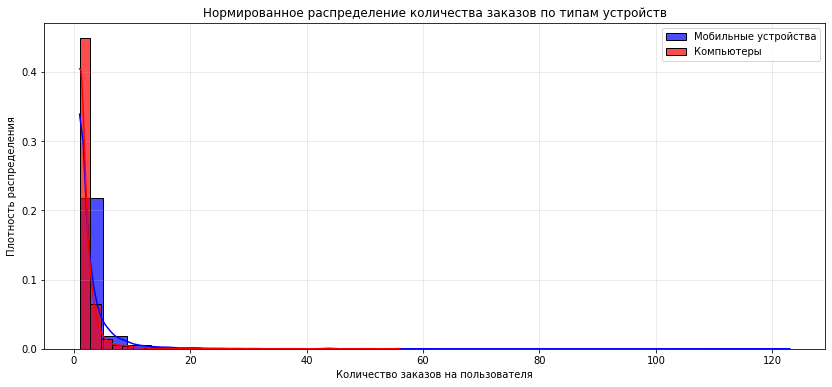

In [78]:
# Строим нормированную гистограмму распределения заказов
plt.figure(figsize=(14, 6))
sns.histplot(mobile_orders, bins=30, label='Мобильные устройства', alpha=0.7, color='blue', stat='density', kde=True)
sns.histplot(desktop_orders, bins=30, label='Компьютеры', alpha=0.7, color='red', stat='density', kde=True)

plt.xlabel('Количество заказов на пользователя')
plt.ylabel('Плотность распределения')
plt.title('Нормированное распределение количества заказов по типам устройств')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

В связи с экспоненциальным распределением данных, наличием выбросов и значительным преобладанием мобильных пользователей над десктопными, для тестирования гипотезы применяется критерий Манна-Уитни.

In [79]:
# Статистическая проверка гипотезы
alpha = 0.05
stat, p_value = mannwhitneyu(mobile_orders, desktop_orders, alternative='greater')

print(f"Результат теста: p-value = {p_value:.5f}")

if p_value > alpha:
    print("Вывод: разница в количестве заказов статистически не значима")
else:
    print("Вывод: мобильные пользователи действительно активнее")

Результат теста: p-value = 0.00000
Вывод: мобильные пользователи действительно активнее


Статистический анализ подтвердил, что пользователи мобильного приложения совершают в среднем больше заказов, чем пользователи стационарных устройств.

Гипотеза 2: Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями ПК.

In [80]:
# Сгруппируем данные по идентификатору пользователя и устройства
time_between_orders = df_autumn.groupby(['user_id', 'device_type_canonical'])['days_since_prev'].mean().reset_index()

# Отберем пользователей мобильных устройств и ПК
grp_mobile = time_between_orders[time_between_orders['device_type_canonical'] == 'mobile']
grp_desktop = time_between_orders[time_between_orders['device_type_canonical'] == 'desktop']

# Проверим пересечение пользователей разных устройств
first_id = set(grp_mobile['user_id'].unique())
second_id = set(grp_desktop['user_id'].unique())

# Анализ пересечения пользователей
intersection_users = first_id & second_id
print(f"Пользователи только мобильных устройств: {len(first_id - second_id)}")
print(f"Пользователи только ПК: {len(second_id - first_id)}")
print(f"Пользователи обоих устройств: {len(intersection_users)}")
print(f"Всего уникальных пользователей: {len(first_id | second_id)}")

# Выводим статистику по времени между заказами
print("\nСтатистика по времени между заказами:")
display(time_between_orders['days_since_prev'].describe())

# Дополнительно: статистика по группам устройств
print("\nСтатистика по мобильным устройствам:")
display(grp_mobile['days_since_prev'].describe())

print("\nСтатистика по ПК:")
display(grp_desktop['days_since_prev'].describe())

Пользователи только мобильных устройств: 10825
Пользователи только ПК: 1618
Пользователи обоих устройств: 3224
Всего уникальных пользователей: 15667

Статистика по времени между заказами:


count    14125.000000
mean        18.938770
std         26.585905
min          0.000000
25%          1.571429
50%          7.769231
75%         24.600000
max        148.000000
Name: days_since_prev, dtype: float64


Статистика по мобильным устройствам:


count    10110.000000
mean        20.574898
std         27.322412
min          0.000000
25%          2.053363
50%          9.500000
75%         27.666666
max        148.000000
Name: days_since_prev, dtype: float64


Статистика по ПК:


count    4015.000000
mean       14.818908
std        24.151087
min         0.000000
25%         1.000000
50%         4.500000
75%        17.000000
max       146.000000
Name: days_since_prev, dtype: float64

In [81]:
# Определяем пользователей с одним типом устройства
unique_device = time_between_orders.groupby('user_id')['device_type_canonical'].nunique().reset_index()
single_device_users = unique_device[unique_device['device_type_canonical'] == 1]['user_id']

# Фильтруем данные: пользователи с одним устройством и без пропусков во времени между заказами
time_between = time_between_orders[
    time_between_orders['user_id'].isin(single_device_users) & 
    time_between_orders['days_since_prev'].notna()
]

# Рассчитываем среднее время между заказами для каждого пользователя и устройства
time_between = time_between.groupby(['user_id', 'device_type_canonical'])['days_since_prev'].mean().reset_index()

# Анализ распределения времени между заказами
print("Статистика времени между заказами:")
display(time_between['days_since_prev'].describe())
display(time_between.head())

Статистика времени между заказами:


count    7894.000000
mean       25.884367
std        30.981144
min         0.000000
25%         2.200000
50%        14.000000
75%        38.000000
max       148.000000
Name: days_since_prev, dtype: float64

,user_id,device_type_canonical,days_since_prev
0,0005ca5e93f2cf4,mobile,75.0
1,000898990054619,mobile,51.0
2,000a55a418c128c,mobile,16.0
3,001e7037d013f0f,mobile,43.5
4,00245c702bc343e,mobile,27.5


In [82]:
# Подготовка данных для сравнения времени между заказами

mobile_interval = time_between.query("device_type_canonical == 'mobile'")['days_since_prev']
desktop_interval = time_between.query("device_type_canonical == 'desktop'")['days_since_prev']

print("Сравнение временных интервалов между заказами:")
print(f"Мобильные устройства (n={len(mobile_interval)}):")
display(mobile_interval.describe())
print(f"Стационарные устройства (n={len(desktop_interval)}):")
display(desktop_interval.describe())

Сравнение временных интервалов между заказами:
Мобильные устройства (n=6994):


count    6994.000000
mean       25.216600
std        30.163080
min         0.000000
25%         2.953416
50%        14.000000
75%        36.000000
max       148.000000
Name: days_since_prev, dtype: float64

Стационарные устройства (n=900):


count    900.000000
mean      31.073647
std       36.325726
min        0.000000
25%        0.000000
50%       16.000000
75%       52.500000
max      146.000000
Name: days_since_prev, dtype: float64

Размер выборки мобильных: 6994
Размер выборки ПК: 900


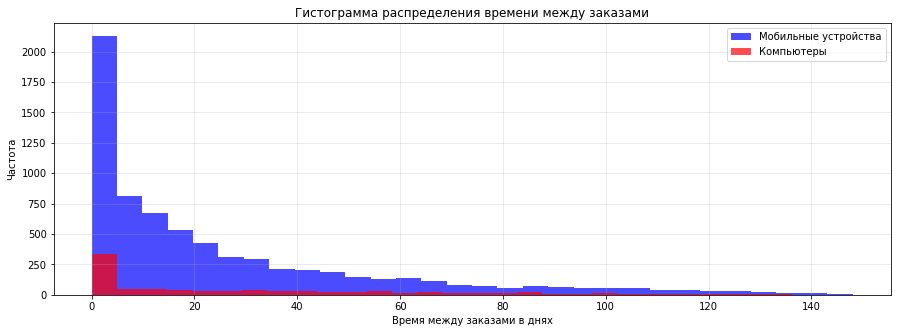

In [83]:
# Сначала создаем переменные с данными о времени между заказами
mobile_times = time_between[time_between['device_type_canonical'] == 'mobile']['days_since_prev']
desktop_times = time_between[time_between['device_type_canonical'] == 'desktop']['days_since_prev']

print(f"Размер выборки мобильных: {len(mobile_times)}")
print(f"Размер выборки ПК: {len(desktop_times)}")

# Построим гистограмму распределения данных для двух выборок
plt.figure(figsize=(15, 5))
plt.hist(mobile_times, bins=30, label='Мобильные устройства', alpha=0.7, color='blue')
plt.hist(desktop_times, bins=30, label='Компьютеры', alpha=0.7, color='red')

plt.xlabel('Время между заказами в днях')
plt.ylabel('Частота')
plt.title('Гистограмма распределения времени между заказами')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Данные демонстрируют экспоненциальное распределение с значительным разбросом значений. В связи с различным размером выборок и характером распределения для сравнения применяется непараметрический критерий Манна-Уитни.

Формулировка гипотез:  
H0 (нулевая гипотеза): Время между заказами пользователей мобильных и стационарных устройств не имеет статистически значимых различий.  
H1 (альтернативная гипотеза): Пользователи мобильных устройств демонстрируют более длительные интервалы между заказами.  

Уровень значимости установлен на стандартном значении α = 0.05.

In [84]:
# Сначала создаем переменные с данными о времени между заказами
mobile_times = time_between[time_between['device_type_canonical'] == 'mobile']['days_since_prev']
desktop_times = time_between[time_between['device_type_canonical'] == 'desktop']['days_since_prev']

print(f"Размер выборки мобильных: {len(mobile_times)}")
print(f"Размер выборки ПК: {len(desktop_times)}")

# Статистическая проверка гипотезы

alpha = 0.05
stat, p_value = mannwhitneyu(mobile_times, desktop_times, alternative='greater')

print(f"\nРезультат теста Манна-Уитни:")
print(f"p-value = {p_value:.5f}")
print(f"Уровень значимости α = {alpha}")

if p_value > alpha:
    print("Нулевая гипотеза не отвергается")
    print("Статистически значимых различий во времени между заказами не обнаружено")
else:
    print("Альтернативная гипотеза подтверждается") 
    print("Мобильные пользователи демонстрируют более длинные интервалы между заказами")

# Дополнительная информация
print(f"\nСреднее время между заказами:")
print(f"Мобильные: {mobile_times.mean():.2f} дней")
print(f"ПК: {desktop_times.mean():.2f} дней")

Размер выборки мобильных: 6994
Размер выборки ПК: 900

Результат теста Манна-Уитни:
p-value = 0.76657
Уровень значимости α = 0.05
Нулевая гипотеза не отвергается
Статистически значимых различий во времени между заказами не обнаружено

Среднее время между заказами:
Мобильные: 25.22 дней
ПК: 31.07 дней


Статистический анализ не выявил значимых различий в интервалах между заказами мобильных и десктопных пользователей в осенний период.

### ВЫВОД
##### ИНФОРМАЦИЯ О ДАННЫХ:  

Предобработка данных и подготовка к исследованию (Количество неявных дубликатов: 30)  
Размер DataFrame после удаления дубликатов: 290819
Количество событий с отсутствующей информацией: 19  
Объединили датафреймы  
Проверили данные на дубликаты и удалили     
Обработали пропуски  

Период: июнь-октябрь 2024 года (5 месяцев)   
Устройства: mobile и desktop пользователи  
Валюты: унифицированы в RUB  

##### ОСНОВНЫЕ РЕЗУЛЬТАТЫ АНАЛИЗА:    


Наиболее востребованные мероприятия:

Лето:
- Концерты - 42.6% (47 447 заказов)
- Театр - 21.3% (23 690 заказов)

Осень:
- Концерты - 37.3% (62 411 заказов)
- Театр - 25.5% (42 702 заказов)
- Спорт - 11.2% (18 763 заказов)

Популярность мероприятий осенью изменилась так:
- Концерты остаются лидером, но их доля снизилась (с 42.6% до 37.3%), хотя количество заказов выросло.
- Театр стал значительно популярнее: доля выросла с 21.3% до 25.5%.
- Спорт пережил взрывной рост: доля выросла в 4.5 раза (с 2.5% до 11.2%).
- Ёлки стали заметным событием: их доля выросла в 4 раза (с 0.002% до 0.01%).
- Категория "Другое" стала менее заметной, снизившись с 25.5% до 19.5%.

Средний чек осенью снизился по большинству популярных категорий:
- Театр: -18.6% (со 216 ₽ до 176 ₽)
- Концерты: -9.3% (с 295 ₽ до 268 ₽)
- Спорт: -9% (с 55 ₽ до 50 ₽)
- При этом вырос для выставок (+6 ₽) и стендапа (+12.6 ₽).

Вывод: Осенью пользователи стали чаще покупать более дешёвые билеты, особенно в театр и на концерты.

Сезонные предпочтения: Осенью общая активность пользователей значительно выше (167 468 заказов против 111 274 летом).

Сдвиг в интересах: Осенью пользователи активно переключаются на спортивные мероприятия и начинают покупать билеты на ёлки.

Изменение платежеспособности/спроса: Падение среднего чека на ключевые категории (театр, концерты) может указывать на рост спроса на более бюджетные события или смену ценовой политики партнеров.

Активность по дням:  
Пики: Вторник и четверг (макс. заказы и активность).  
Снижение: Выходные дни (мин. показатели).  
Сравнение: В будни заказов на пользователя почти в 2 раза выше (9.7 vs 5.7), чем в выходные.  
Пользователи демонстрируют более высокую активность в будние дни — среднее количество заказов на человека превышает показатели выходных. Наибольшая активность сосредоточена в середине недели.

Явные лидеры по числу заказов и выручке с продажи билетов есть:  
Регионы: Каменевский регион — абсолютный лидер по заказам (85 376), значительно опережая Североярскую область (43 474).  
Партнёры: Лидер по выручке — «Билеты без проблем» (23.8 млн), хотя по количеству заказов он уступает «Лови билет!» и «Билеты в руки».  


**РЕЗУЛЬТАТЫ ПРОВЕРКИ ГИПОТЕЗ:**  
Среднее время между заказами: Мобильные: 25.22 дней и ПК: 31.07 дней.  
Пользователи только мобильных устройств: 10825 и пользователи только ПК: 1618  

Гипотеза 1: Время между заказами  
Результат: Нет статистически значимых различий между устройствами  
Метод: Тест Манна-Уитни  
Вывод: H1 не отвергается  

Гипотеза 2: Количество заказов на пользователя  
Результат: Mobile-пользователи совершают статистически значимо больше заказов  
Метод: Тест Манна-Уитни (экспоненциальное распределение данных)  
Вывод: H0 подтверждена  

Ключевой инсайт: Mobile-аудитория более активна в частоте покупок, но периодичность заказов у обеих групп одинакова.



##### КЛЮЧЕВЫЕ РЕКОМЕНДАЦИИ:

ОПТИМИЗАЦИЯ ПОЛЬЗОВАТЕЛЬСКОГО ОПЫТА:  
• Приоритетное развитие мобильного приложения  
• Внедрение бонусных программ для постоянных клиентов   
• Планирование акций на дни пиковой активности (вторник-четверг)  

КОНТЕНТНАЯ СТРАТЕГИЯ:  
• Систематизация информации о мероприятиях  
• Расширение ассортимента для аудитории 18+  
• Развитие спортивного направления  

РЕГИОНАЛЬНАЯ ЭКСПАНСИЯ:  
• Диверсификация за пределы топ-3 регионов  
• Укрепление позиций в ключевых регионах  
• Развитие партнерской сети  

МАРКЕТИНГОВАЯ СТРАТЕГИЯ: 
• Анализ эффективности акционных кампаний  
• Баланс между агрессивными скидками и ценовой стабильностью  
• Диверсификация партнерской сети билетных операторов  

ВАЖНЫЕ ИНСАЙТЫ:
• Осенний рост обусловлен комплексно: сезонность + смена предпочтений  
• Mobile-аудитория более вовлеченная, но с одинаковой периодичностью покупок  
• Высокая концентрация бизнеса создает риски зависимости  
• Ценовая политика требует тонкой настройки под сезонные изменения  

ПЕРСПЕКТИВЫ ДАЛЬНЕЙШЕГО ИССЛЕДОВАНИЯ:  
• Глубокий анализ факторов частоты покупок  
• Исследование причин ценовых изменений по категориям  
• Сегментация пользователей по поведенческим паттернам  
• Оптимизация партнерской стратегии  